<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 1**
- Amanda Tofthagen, 113124
- Tora Kristine Løtveit, 112927
- Tuva Grønvold Natvig, 113107

<H2>Main facilities</H2>

#### Loading and preproccesing data (using with functions made in project 1)

In [36]:
import nltk  
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import normalize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/torakristinelotveit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/torakristinelotveit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/torakristinelotveit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/torakristinelotveit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Convert text to lower case and tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [token for token in tokens if token not in punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Load metadata as both dataframe and list
def load_metadata(file_path):
    df = pd.read_csv(file_path, low_memory=False)
    df = df[['cord_uid', 'title', 'abstract', 'authors', 'journal']].dropna()  # Keep only required columns
    df['document'] = df.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
   
    # Store as a list of "title + abstract" for ranking models
    doc_list = df['document'].tolist()
    
    return df, doc_list  # Return both formats


# Load qrels
def load_qrels(file_path):
    qrels = defaultdict(dict)
    with open(file_path, 'r') as f:
        for line in f:
            topic_id, _, doc_id, relevance = line.strip().split()
            qrels[topic_id][doc_id] = int(relevance)
    return qrels

def load_queries(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    queries = {}
    for topic in root.findall('topic'):
        topic_number = topic.get('number')
        query_text = preprocess_text(topic.find('query').text)
        queries[topic_number] = " ".join(query_text)  # Ensure consistency
    return queries

metadata_path = "data2/metadata.csv"
qrels_path = "data2/qrels.txt"
queries_path = "data2/topics.xml"

D, D_list = load_metadata(metadata_path)
qrels = load_qrels(qrels_path)
queries = load_queries(queries_path)


<h3>Part I: clustering</h3>

*A) Clustering*

In [38]:
class BM25Vectorizer:
    """
    Vectorize documents using the BM25 algorithm that convert text data into a numerical
    form that retains textual information in a format suitable for the clustering algorithm 
    """
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        # min_df (minimum document frequency) is set to ignore terms that appear too infrequently (in than 1% of the documents)
        # max_df (maximum document frequency) is set to ignore terms that appear too frequently (in more than 50% of the documents)
        self.vectorizer = TfidfVectorizer(tokenizer=self.LemmaTokenizer(), min_df=0.01, max_df=0.5)

    class LemmaTokenizer:
        def __init__(self):
            self.wnl = WordNetLemmatizer()
        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if t not in punctuation]

    def transform(self, docs): 
        doc_vectors = []
        for doc in docs:
            doc_tokens = self.vectorizer.build_tokenizer()(doc)
            doc_scores = self.bm25.get_scores(doc_tokens)
            doc_vectors.append(doc_scores)
        return normalize(np.array(doc_vectors), axis=0)

    def fit_transform(self, docs):
        self.terms = self.vectorizer.fit(docs).get_feature_names_out()
        tokenized_docs = [self.vectorizer.build_tokenizer()(doc) for doc in docs]
        self.bm25 = BM25Okapi(tokenized_docs, k1=self.k1, b=self.b)
        vectors = self.transform(docs)  
        return vectors

In [39]:
def determine_number_of_clusters(D, max_k):
    """
    Function to determine the best number of clusters, 
    based on the elbow point and silhouette score
    """
    # First step: Use elbow method to narrow down the range of potential values for k
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(D)
        distortions.append(kmeans.inertia_)
    
    accelerations = np.diff(distortions, 2) # Compute second derivative (accelerations)
    elbow_point = np.argmin(accelerations) # find the "elbow" by looking at the second derivative of the distortions list 

    # Second step: Calculate silhouette scores for values up to the elbow point
    k_range = range(2, elbow_point + 1) 
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(D)
        score = silhouette_score(D, labels)
        silhouette_scores.append(score)
    

    # Select the best k based on the highest silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    return best_k

/Users/torakristinelotveit/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[{'centroid': array([0.10073201, 0.06141662, 0.10562166, 0.10454464, 0.11108264,
       0.01415858, 0.09430702, 0.10526288, 0.10968007, 0.10679113,
       0.09889631, 0.09909847, 0.10698906, 0.10856958, 0.10567604,
       0.10377129, 0.10814196, 0.1048628 , 0.09976549, 0.10570388,
       0.0981736 , 0.10251131, 0.10066474, 0.10565992, 0.1091258 ,
       0.09922779, 0.10583557, 0.10512557, 0.11028832, 0.10864487,
       0.10350321, 0.09240547, 0.10598113, 0.10838413, 0.11157126,
       0.10445343, 0.10802013, 0.10287126, 0.10534537, 0.10660117,
       0.09687115, 0.10276329, 0.1034244 , 0.10575943, 0.10074689,
       0.10029429, 0.10318544, 0.10826193, 0.09723989, 0.10903817,
       0.10513244, 0.10598238, 0.1074784 , 0.10170137, 0.10731698,
       0.1087041 , 0.10548091, 0.10064523, 0.10820736, 0.10612716,
       0.1031745 , 0.10547372, 0.1076859 , 0.10569363, 0.10214202,
       0.09319025, 0.10165724, 0.10580295, 0.09444844, 0.10248236,
       0.11143915, 0.09596733, 0.10933786, 0.099

/Users/torakristinelotveit/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


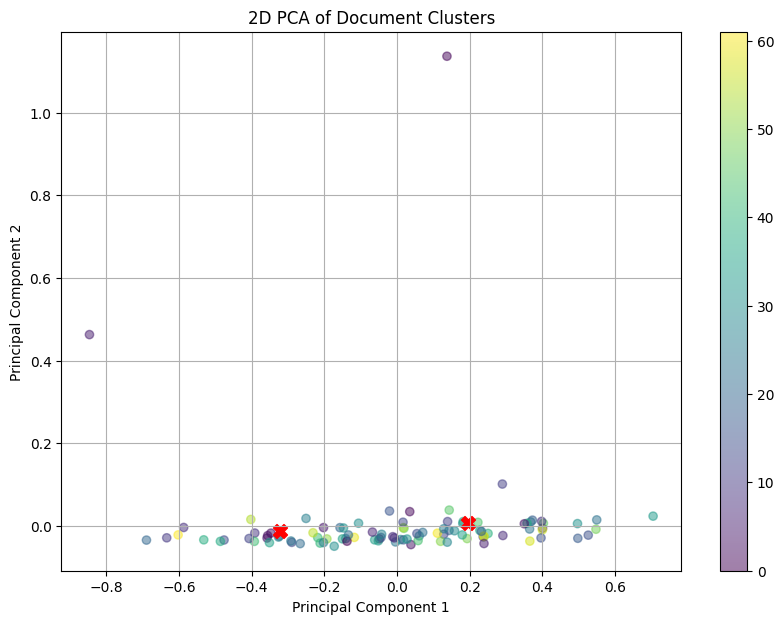

In [40]:
def clustering(D, args=None):
    if args is None:
        args = {}

    # Extract algorithm and maximum number of clusters to evaluate from args:
    algorithm = args.get('algorithm', 'kmeans') # Default algorithm is k-means
    max_k = args.get('max_k', 10) # Default maximum k to evaluate
    vectorizer = args.get('vectorizer', BM25Vectorizer())

    # Prepare document vectors
    document_text = D.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
    document_vectors = vectorizer.fit_transform(document_text)

    # Determine the best number of clusters (if not provided)
    if 'num_clusters' not in args:
        num_clusters = determine_number_of_clusters(document_vectors, max_k)
    else:
        num_clusters = args['num_clusters']

    # Apply the chosen clustering algorithm
    if algorithm == 'kmeans':
        model = KMeans(n_clusters=num_clusters, random_state=42)
        labels = model.fit_predict(document_vectors)
        centroids = model.cluster_centers_
    else:
        # Add more clustering algorithms as needed
        raise ValueError("Unsupported algorithm")

   # Group document IDs by cluster
    clusters = {i: [] for i in range(num_clusters)}
    for idx, label in enumerate(labels):
        clusters[label].append(D.iloc[idx]['cord_uid'])

    # Generate output
    clustering_solution = []
    for i in range(num_clusters):
        cluster_info = {
            'centroid': centroids[i] if 'centroids' in locals() else None,
            'documents': clusters[i]
        }
        clustering_solution.append(cluster_info)

    return clustering_solution


def plot_clusters_pca(document_vectors, labels, centroids):
    pca = PCA(n_components=2)  # Reduce dimensions to 2 for visualization
    reduced_data = pca.fit_transform(document_vectors)
    reduced_centroids = pca.transform(centroids)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
    
    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='X', s=100)
    
    plt.colorbar(scatter)
    plt.title('2D PCA of Document Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()



# Example usage (with sample size):
sample_size = 100
sample_indices = random.sample(range(len(D)), sample_size)
D_sample = D.iloc[sample_indices]
sample_cluster_result = clustering(D_sample)
print(sample_cluster_result)

# Extract document vectors and labels for visualization
vectorizer = BM25Vectorizer()
document_text = D_sample.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
document_vectors = vectorizer.fit_transform(document_text)
labels = [label for cluster in sample_cluster_result for label in [cluster['documents'].index(doc_id) for doc_id in cluster['documents']]]

# Assuming centroids are extracted correctly from the clustering function
centroids = np.array([cluster['centroid'] for cluster in sample_cluster_result if 'centroid' in cluster])

# Call the visualization function
plot_clusters_pca(document_vectors, labels, centroids)

*B) Summarization*

In [41]:
def interpret(cluster, D, args=None):
    if args is None:
        args = {}

    # Retrieve document IDs from the cluster
    document_ids = cluster['documents']
    
    # Filter DataFrame for documents in the cluster
    cluster_data = D[D['cord_uid'].isin(document_ids)]

    # Combine the desired fields into a single string for vectorization
    document_texts = cluster_data.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)

    # Prepare document vectors using BM25Vectorizer or any provided vectorizer
    vectorizer = args.get('vectorizer', BM25Vectorizer())
    document_vectors = vectorizer.fit_transform(document_texts)

    # Compute the median vector
    median_vector = np.median(document_vectors, axis=0)
    

    # Compute the medoid
    if len(document_vectors) > 1:
        distance_matrix = euclidean_distances(document_vectors, document_vectors)
        medoid_index = np.argmin(np.sum(distance_matrix, axis=0))
        medoid_document_content = cluster_data.iloc[medoid_index]['title']  # Fetching title or any other identifier
    else:
        medoid_document_content = cluster_data.iloc[0]['title']  # In case there's only one document in the cluster

    # Description based on median and medoid
    description = {
        'median_vector': median_vector,
        'medoid_document_title': medoid_document_content
    }

    return description


# Example ussage: assuming 'D_sample' is a DataFrame version of your document data including 'cord_uid'
for cluster in sample_cluster_result:
    description = interpret(cluster, D_sample)  
    print("Cluster Description:", description)

/Users/torakristinelotveit/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Cluster Description: {'median_vector': array([0.09474249, 0.04358616, 0.10085718, 0.0837279 , 0.0989819 ,
       0.09138414, 0.08820888, 0.10506769, 0.09847374, 0.10381162,
       0.10200382, 0.08839152, 0.09157772, 0.10048359, 0.10912165,
       0.10881481, 0.10460498, 0.08255242, 0.09811665, 0.10495657,
       0.11092721, 0.10207126, 0.09633118, 0.10465402, 0.10057422,
       0.09469505, 0.09009216, 0.09493503, 0.10184364, 0.08898529,
       0.10706685, 0.10224308, 0.10517202, 0.09407985, 0.09830813,
       0.09273557, 0.10414939, 0.09665812, 0.10348816, 0.08170602,
       0.10052924, 0.09703985, 0.11042906, 0.08729742, 0.09236958,
       0.10120769, 0.10212251, 0.10310513, 0.10077293, 0.10083698,
       0.10006276, 0.10248945, 0.0878453 , 0.09257806, 0.09766424,
       0.09828687, 0.11098713, 0.09386178, 0.08790552, 0.10039552,
       0.09935454, 0.10017138]), 'medoid_document_title': 'Activation of influenza viruses by proteases from host cells and bacteria in the human airway epit

/Users/torakristinelotveit/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


*C) Evaluation*

In [42]:
def evaluate(D, args):
    if args is None:
        args = {}

    clustering_results = args.get('clustering_results')
    vectorizer = args.get('vectorizer', BM25Vectorizer())
    document_text = D.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
    document_vectors = vectorizer.fit_transform(document_text)

    # Create a mapping from document IDs to their indices
    doc_id_to_index = {uid: idx for idx, uid in enumerate(D['cord_uid'])}

    # Prepare labels for silhouette score and initialize metrics
    labels = np.empty(len(D), dtype=int)
    sse = 0
    cohesion = 0
    all_distances = euclidean_distances(document_vectors)

    for cluster_index, cluster in enumerate(clustering_results):
        # Convert document IDs to indices using the map
        cluster_doc_indices = [doc_id_to_index[doc_id] for doc_id in cluster['documents'] if doc_id in doc_id_to_index]

        for doc_index in cluster_doc_indices:
            labels[doc_index] = cluster_index
            sse += np.sum((document_vectors[doc_index] - cluster['centroid']) ** 2)
            cohesion += np.sum(all_distances[doc_index][cluster_doc_indices])

    # Calculate separation
    separation = float('inf')
    for i, cluster_a in enumerate(clustering_results):
        for j, cluster_b in enumerate(clustering_results):
            if i != j:
                # Extract all pairwise distances between two clusters
                a_indices = [doc_id_to_index[doc_id] for doc_id in cluster_a['documents'] if doc_id in doc_id_to_index]
                b_indices = [doc_id_to_index[doc_id] for doc_id in cluster_b['documents'] if doc_id in doc_id_to_index]
                inter_cluster_distances = all_distances[a_indices, :][:, b_indices]
                if inter_cluster_distances.size > 0:
                    separation = min(separation, np.min(inter_cluster_distances))

    # Calculate Silhouette Coefficient
    silhouette_avg = silhouette_score(document_vectors, labels)

    evaluation_metrics = {
        'Silhouette Coefficient': silhouette_avg,
        'Sum of Squared Errors (SSE)': sse,
        'Cohesion': cohesion,
        'Separation': separation
    }

    return evaluation_metrics

# Example usage
args = {
    'clustering_results': sample_cluster_result,  # Assume this variable holds your clustering output
    'vectorizer': BM25Vectorizer()
}
evaluate_results = evaluate(D_sample, args)
print(evaluate_results)

/Users/torakristinelotveit/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


{'Silhouette Coefficient': 0.16801128401758214, 'Sum of Squared Errors (SSE)': 23.954426830744726, 'Cohesion': 3613.9949346653275, 'Separation': 0.3828856695282347}


<h3>Part II: classification</h3>

*A) Feature extraction*

In [43]:
#Function to extract features from documents using TF-IDF
def extract_features(doc_list):
    processed_docs = []
    for doc in doc_list:
        tokens = preprocess_text(doc)  
        processed_docs.append(" ".join(tokens)) 
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_docs)
    return tfidf_matrix, vectorizer

# Usage
tfidf_matrix, vectorizer = extract_features(D_list)


*B) Classification*

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Function to build a classification dataset (without BM25)
def build_classification_dataset(qrels, queries, D, vectorizer, max_neg_per_query=20):
    X, y = [], []

    # Map cord_uid to row index
    cord_uid_to_index = {uid: idx for idx, uid in enumerate(D['cord_uid'])}

    # Preprocess and vectorize all documents
    processed_docs = [" ".join(preprocess_text(text)) for text in D['document']]
    doc_vectors = vectorizer.transform(processed_docs)

    for topic_id, docs in qrels.items():
        if topic_id not in queries:
            continue

        query_text = queries[topic_id]
        query_vec = vectorizer.transform([query_text])

        # Positive samples
        for doc_id, rel in docs.items():
            doc_idx = cord_uid_to_index.get(doc_id)
            if doc_idx is None:
                continue
            label = 1 if rel > 0 else 0
            doc_vec = doc_vectors[doc_idx]
            combined = 0.5 * query_vec + 0.5 * doc_vec
            X.append(combined.toarray()[0])
            y.append(label)

        # Negative samples
        neg_added = 0
        for i, doc_id in enumerate(D['cord_uid']):
            if doc_id in docs or neg_added >= max_neg_per_query:
                continue
            doc_vec = doc_vectors[i]
            combined = 0.5 * query_vec + 0.5 * doc_vec
            X.append(combined.toarray()[0])
            y.append(0)
            neg_added += 1

    return np.array(X), np.array(y)

# Build and train
X, y = build_classification_dataset(qrels, queries, D, vectorizer)
print("Shape of X:", X.shape)
print("Positive samples:", sum(y))
print("Negative samples:", len(y) - sum(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

clf = LogisticRegression(max_iter=200, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

*C) Ranking extension*

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx

# Function to vectorize queries
def vectorize_queries(queries_dict, vectorizer):
    query_vectors = {}
    for qid, query in queries_dict.items():
        query_vec = vectorizer.transform([query]) 
        query_vectors[qid] = query_vec
    return query_vectors

# Function to get top-k documents for each query, based on cosine similarity
def get_top_k_documents_per_query(query_vectors, doc_matrix, top_k=1000):
    top_docs = {}
    for qid, qvec in query_vectors.items():
        sims = cosine_similarity(qvec, doc_matrix).flatten()
        top_indices = np.argsort(sims)[::-1][:top_k]
        top_scores = sims[top_indices]
        top_docs[qid] = list(zip(top_indices, top_scores))  # (doc_id, similarity)
    return top_docs


# Function to build an undirected graph where edges are added between documents
# based on cosine similarity above a certain threshold
def build_graph(doc_indices, doc_matrix, theta=0.2):
    G = nx.Graph()
    docs_subset = doc_matrix[doc_indices]

    sim_matrix = cosine_similarity(docs_subset)

    for i, idx1 in enumerate(doc_indices):
        for j, idx2 in enumerate(doc_indices):
            if i < j and sim_matrix[i, j] >= theta:
                G.add_edge(idx1, idx2, weight=sim_matrix[i, j])
    return G

# Function to run PageRank on the similarity graph
def run_pagerank(graph, p=0.15, max_iter=100):
    return nx.pagerank(graph, alpha=1 - p, max_iter=max_iter)

# Function to rerank documents using PageRank based on importance
# of documents in the similarity graph
def undirected_page_rank(qid, tfidf_matrix, top_docs_per_query, theta=0.2):
    if qid not in top_docs_per_query:
        print(f"Query {qid} not found.")
        return []

    top_docs = [doc_id for doc_id, _ in top_docs_per_query[qid]]
    G = build_graph(top_docs, tfidf_matrix, theta=theta)
    scores = run_pagerank(G)

    reranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return reranked


# Function to rerank documents using PageRank with a combination of original score
# and PageRank score
def undirected_page_rank_fused(qid, tfidf_matrix, top_docs_per_query, theta=0.2, alpha=0.6):
    if qid not in top_docs_per_query:
        print(f"Query {qid} not found.")
        return []

    # Get top-1000 document indices
    doc_indices = [doc_id for doc_id, _ in top_docs_per_query[qid]]
    original_scores = dict(top_docs_per_query[qid])  # doc_id → cosine_sim

    # Build graph
    G = build_graph(doc_indices, tfidf_matrix, theta=theta)
    pr_scores = run_pagerank(G)

    # Combine original score with PageRank
    combined_scores = {
        doc_id: alpha * pr_scores.get(doc_id, 0) + (1 - alpha) * original_scores.get(doc_id, 0)
        for doc_id in doc_indices
    }

    reranked = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    return reranked


# Example usage


# Step 1: Vectorize queries
query_vectors = vectorize_queries(queries, vectorizer)

# Step 2: Find top-1000 most similar docs per query
top_docs_per_query = get_top_k_documents_per_query(query_vectors, tfidf_matrix)

# Step 3: Rerank one query using PageRank
qid = list(top_docs_per_query.keys())[0]
reranked_docs = undirected_page_rank(qid, tfidf_matrix, top_docs_per_query, theta=0.2)

# Show top 5 reranked docs
print(f"Top 5 reranked documents for query {qid}:")
for doc_id, score in reranked_docs[:5]:
    print(f"Doc {doc_id} → PR score: {score:.6f}")
    print(D.iloc[doc_id][['cord_uid', 'title']])



Top 5 reranked documents for query 1:
Doc 29578 → PR score: 0.005363
cord_uid                                             wl121lg4
title       Molecular immune pathogenesis and diagnosis of...
Name: 41082, dtype: object
Doc 28394 → PR score: 0.004964
cord_uid                                             wh9vvgv2
title       T-cell immunity of SARS-CoV: Implications for ...
Name: 39654, dtype: object
Doc 35387 → PR score: 0.004803
cord_uid                                             msohf5oa
title       The origin, transmission and clinical therapie...
Name: 48161, dtype: object
Doc 4163 → PR score: 0.004793
cord_uid                                             nj1p4ehx
title       T-cell-mediated immune response to respiratory...
Name: 4373, dtype: object
Doc 26483 → PR score: 0.004590
cord_uid                                             4fs724wn
title       Liver injury during highly pathogenic human co...
Name: 34455, dtype: object


*D) Evaluation*

In [ ]:
from sklearn.metrics import ndcg_score

# Function to get the true relevance scores for a given query from qrels
def get_qrels_for_query(qid, qrels):
    return qrels.get(qid, {})

#Function to measure precision at k
def precision_at_k(ranked_docs, relevant_docs, k=10):
    top_k = ranked_docs[:k]
    relevant = [1 if doc_id in relevant_docs and relevant_docs[doc_id] > 0 else 0 for doc_id in top_k]
    return sum(relevant) / k

# Function to calculate Mean Average Precision (MAP) for a ranked list of documents for a query
def mean_average_precision(ranked_docs, relevant_docs):
    num_relevant = 0
    avg_precision = 0.0

    for i, doc_id in enumerate(ranked_docs):
        if doc_id in relevant_docs and relevant_docs[doc_id] > 0:
            num_relevant += 1
            avg_precision += num_relevant / (i + 1)

    if num_relevant == 0:
        return 0.0
    return avg_precision / num_relevant

# Function to calculate NDCG at k
def ndcg_at_k(ranked_docs, relevant_docs, k=10):
    true_rels = [relevant_docs.get(doc_id, 0) for doc_id in ranked_docs[:k]]
    ideal_rels = sorted(relevant_docs.values(), reverse=True)[:k]

    if not ideal_rels:
        return 0.0

    return ndcg_score([ideal_rels], [true_rels])

# Function to evaluate the baseline cosine similarity ranking
def evaluate_baseline_cosine(qrels, tfidf_matrix, query_vectors, D, top_k=1000):
    D_reset = D.reset_index(drop=True)
    index_to_uid = dict(enumerate(D_reset['cord_uid']))

    all_precisions, all_maps, all_ndcgs = [], [], []
    evaluated_queries = 0

    for qid, qvec in query_vectors.items():
        sims = cosine_similarity(qvec, tfidf_matrix).flatten()
        top_indices = np.argsort(sims)[::-1][:top_k]
        ranked_doc_ids = [index_to_uid[idx] for idx in top_indices]

        relevant_docs = get_qrels_for_query(qid, qrels)
        if not relevant_docs:
            continue

        p_at_10 = precision_at_k(ranked_doc_ids, relevant_docs, k=10)
        avg_prec = mean_average_precision(ranked_doc_ids, relevant_docs)
        ndcg = ndcg_at_k(ranked_doc_ids, relevant_docs, k=10)

        all_precisions.append(p_at_10)
        all_maps.append(avg_prec)
        all_ndcgs.append(ndcg)
        evaluated_queries += 1

    print(f"\n📊 Baseline Cosine Similarity Ranking (no graph):")
    print(f"Evaluated {evaluated_queries} queries.")
    print(f"Avg Precision@10: {sum(all_precisions)/evaluated_queries:.4f}")
    print(f"Avg MAP:          {sum(all_maps)/evaluated_queries:.4f}")
    print(f"Avg NDCG@10:      {sum(all_ndcgs)/evaluated_queries:.4f}")


def evaluate_all_queries_fused(qrels, tfidf_matrix, top_docs_per_query, D, alpha=0.6, theta=0.2):
    D_reset = D.reset_index(drop=True)
    index_to_uid = dict(enumerate(D_reset['cord_uid']))

    all_precisions, all_maps, all_ndcgs = [], [], []
    evaluated_queries = 0

    for qid in top_docs_per_query:
        # ⚠️ Pass theta into your fused PageRank function
        reranked = undirected_page_rank_fused(qid, tfidf_matrix, top_docs_per_query, alpha=alpha, theta=theta)
        reranked_doc_ids = [index_to_uid[idx] for idx, _ in reranked]

        relevant_docs = get_qrels_for_query(qid, qrels)
        if not relevant_docs:
            continue

        p10 = precision_at_k(reranked_doc_ids, relevant_docs, k=10)
        map_ = mean_average_precision(reranked_doc_ids, relevant_docs)
        ndcg = ndcg_at_k(reranked_doc_ids, relevant_docs, k=10)

        all_precisions.append(p10)
        all_maps.append(map_)
        all_ndcgs.append(ndcg)
        evaluated_queries += 1

    print(f"\n📊 Fused Ranking (alpha={alpha}, θ={theta}):")
    print(f"Avg Precision@10: {sum(all_precisions)/evaluated_queries:.4f}")
    print(f"Avg MAP:          {sum(all_maps)/evaluated_queries:.4f}")
    print(f"Avg NDCG@10:      {sum(all_ndcgs)/evaluated_queries:.4f}")


# Ensure the DataFrame has a clean integer index
D_reset = D.reset_index(drop=True)

# Build index-to-uid map safely
index_to_uid = dict(enumerate(D_reset['cord_uid']))
reranked_doc_ids = [index_to_uid[idx] for idx, _ in reranked_docs]


# Function to evaluate all queries
def evaluate_all_queries(qrels, tfidf_matrix, top_docs_per_query, D, theta=0.2):
    D_reset = D.reset_index(drop=True)
    index_to_uid = dict(enumerate(D_reset['cord_uid']))

    all_precisions = []
    all_maps = []
    all_ndcgs = []
    evaluated_queries = 0

    for qid in qrels.keys():
        if qid not in top_docs_per_query:
            continue

        # Pass the theta value into the graph builder
        reranked_docs = undirected_page_rank(qid, tfidf_matrix, top_docs_per_query, theta=theta)
        reranked_doc_ids = [index_to_uid.get(idx) for idx, _ in reranked_docs if idx in index_to_uid]

        relevant_docs = get_qrels_for_query(qid, qrels)
        if not relevant_docs:
            continue

        p_at_10 = precision_at_k(reranked_doc_ids, relevant_docs, k=10)
        avg_prec = mean_average_precision(reranked_doc_ids, relevant_docs)
        ndcg = ndcg_at_k(reranked_doc_ids, relevant_docs, k=10)

        all_precisions.append(p_at_10)
        all_maps.append(avg_prec)
        all_ndcgs.append(ndcg)
        evaluated_queries += 1

    avg_p10 = sum(all_precisions) / evaluated_queries if evaluated_queries > 0 else 0.0
    avg_map = sum(all_maps) / evaluated_queries if evaluated_queries > 0 else 0.0
    avg_ndcg = sum(all_ndcgs) / evaluated_queries if evaluated_queries > 0 else 0.0

    print(f"\nEvaluated {evaluated_queries} queries with θ = {theta}")
    print(f"Average Precision@10: {avg_p10:.4f}")
    print(f"Average MAP: {avg_map:.4f}")
    print(f"Average NDCG@10: {avg_ndcg:.4f}")


#
# Evaluate baseline cosine similarity ranking
evaluate_baseline_cosine(qrels, tfidf_matrix, query_vectors, D)
# Evaluate with different θ values
for theta in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    evaluate_all_queries(qrels, tfidf_matrix, top_docs_per_query, D, theta=theta)
    evaluate_all_queries_fused(qrels, tfidf_matrix, top_docs_per_query, D, theta=theta)
    # Evaluate the fused function with different α values
best_theta = 0.2
# Evaluate with different α values
for alpha in [0.3, 0.5, 0.7]:
    evaluate_all_queries_fused(qrels, tfidf_matrix, top_docs_per_query, D, alpha=alpha, theta=best_theta)







📊 Baseline Cosine Similarity Ranking (no graph):
Evaluated 30 queries.
Avg Precision@10: 0.3100
Avg MAP:          0.2190
Avg NDCG@10:      0.9926

Evaluated 30 queries with θ = 0.1
Average Precision@10: 0.0767
Average MAP: 0.0614
Average NDCG@10: 0.9940

📊 Fused Ranking (alpha=0.6, θ=0.1):
Avg Precision@10: 0.3100
Avg MAP:          0.2199
Avg NDCG@10:      0.9926

Evaluated 30 queries with θ = 0.2
Average Precision@10: 0.0700
Average MAP: 0.0571
Average NDCG@10: 0.9940

📊 Fused Ranking (alpha=0.6, θ=0.2):
Avg Precision@10: 0.3100
Avg MAP:          0.2203
Avg NDCG@10:      0.9926

Evaluated 30 queries with θ = 0.3
Average Precision@10: 0.0667
Average MAP: 0.0545
Average NDCG@10: 0.9940

📊 Fused Ranking (alpha=0.6, θ=0.3):
Avg Precision@10: 0.3100
Avg MAP:          0.2205
Avg NDCG@10:      0.9926

Evaluated 30 queries with θ = 0.4
Average Precision@10: 0.0433
Average MAP: 0.0575
Average NDCG@10: 0.9940

📊 Fused Ranking (alpha=0.6, θ=0.4):
Avg Precision@10: 0.3167
Avg MAP:          0.219

Weighted PageRank

In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import time

# Function to rerank documents using undirected PageRank with weighted edges and classifier-based priors
def undirected_page_rank_weighted(
    qid,
    tfidf_matrix,
    top_docs_per_query,
    classifier=None,
    doc_vectors=None,
    query_vectors=None,
    theta=0.2,
    p=0.15,
    max_iter=50,
    top_k_neighbors=10,
    use_cosine_fusion=False,
    alpha=0.6
):
    if qid not in top_docs_per_query:
        return []

    doc_indices = [doc_id for doc_id, _ in top_docs_per_query[qid]]
    docs_subset = tfidf_matrix[doc_indices]
    sim_matrix = cosine_similarity(docs_subset)

    G = nx.Graph()
    for i, idx1 in enumerate(doc_indices):
        sim_scores = list(enumerate(sim_matrix[i]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        for j, score in sim_scores[:top_k_neighbors + 1]:
            idx2 = doc_indices[j]
            if i < j and score >= theta:
                G.add_edge(idx1, idx2, weight=score)

    if classifier and doc_vectors is not None and query_vectors is not None:
        qvec = query_vectors[qid]
        priors = {}
        for i, idx in enumerate(doc_indices):
            dvec = doc_vectors[idx]
            combined = 0.5 * qvec + 0.5 * dvec
            features = combined.toarray()
            clf_score = classifier.predict_proba(features)[0][1]
            priors[idx] = clf_score ** 2
    else:
        priors = {idx: 1.0 for idx in doc_indices}

    total_prior = sum(priors.values())
    priors = {k: v / total_prior for k, v in priors.items()}

    PR = {node: 1 / len(G) for node in G.nodes()}
    for _ in range(max_iter):
        new_PR = {}
        for node in G.nodes():
            neighbors = list(G[node])
            link_sum = 0.0
            for neighbor in neighbors:
                weight = G[neighbor][node]['weight']
                total_weight = sum(G[neighbor][n]['weight'] for n in G[neighbor])
                link_sum += PR[neighbor] * (weight / total_weight)
            new_PR[node] = p * priors[node] + (1 - p) * link_sum
        PR = new_PR

    if use_cosine_fusion:
        cosine_scores = dict(top_docs_per_query[qid])
        reranked = [(doc_id, alpha * PR.get(doc_id, 0.0) + (1 - alpha) * cosine_scores.get(doc_id, 0.0))
                    for doc_id in doc_indices]
        reranked = sorted(reranked, key=lambda x: x[1], reverse=True)
    else:
        reranked = sorted(PR.items(), key=lambda x: x[1], reverse=True)

    return reranked



# Evaluation function
def evaluate_all_queries_weighted(
    qrels,
    tfidf_matrix,
    top_docs_per_query,
    classifier,
    doc_vectors,
    query_vectors,
    D,
    theta=0.2,
    p=0.15,
    max_iter=50,
    top_k_neighbors=10,
    use_cosine_fusion=False,
    alpha=0.6,
    limit_queries=None
):
    from sklearn.metrics import ndcg_score

    def get_qrels_for_query(qid, qrels):
        return qrels.get(qid, {})

    def precision_at_k(ranked_docs, relevant_docs, k=10):
        top_k = ranked_docs[:k]
        relevant = [1 if doc_id in relevant_docs and relevant_docs[doc_id] > 0 else 0 for doc_id in top_k]
        return sum(relevant) / k

    def mean_average_precision(ranked_docs, relevant_docs):
        num_relevant = 0
        avg_precision = 0.0
        for i, doc_id in enumerate(ranked_docs):
            if doc_id in relevant_docs and relevant_docs[doc_id] > 0:
                num_relevant += 1
                avg_precision += num_relevant / (i + 1)
        return avg_precision / num_relevant if num_relevant > 0 else 0.0

    def ndcg_at_k(ranked_docs, relevant_docs, k=10):
        true_rels = [relevant_docs.get(doc_id, 0) for doc_id in ranked_docs[:k]]
        ideal_rels = sorted(relevant_docs.values(), reverse=True)[:k]
        return ndcg_score([ideal_rels], [true_rels]) if ideal_rels else 0.0

    start = time.time()
    D_reset = D.reset_index(drop=True)
    index_to_uid = dict(enumerate(D_reset['cord_uid']))

    all_precisions, all_maps, all_ndcgs = [], [], []
    evaluated_queries = 0

    for i, qid in enumerate(qrels.keys()):
        if limit_queries and i >= limit_queries:
            break
        if qid not in top_docs_per_query:
            continue

        reranked_docs = undirected_page_rank_weighted(
            qid=qid,
            tfidf_matrix=tfidf_matrix,
            top_docs_per_query=top_docs_per_query,
            classifier=classifier,
            doc_vectors=doc_vectors,
            query_vectors=query_vectors,
            theta=theta,
            p=p,
            max_iter=max_iter,
            top_k_neighbors=top_k_neighbors,
            use_cosine_fusion=use_cosine_fusion,
            alpha=alpha
        )

        reranked_doc_ids = [index_to_uid.get(idx) for idx, _ in reranked_docs if idx in index_to_uid]
        relevant_docs = get_qrels_for_query(qid, qrels)
        if not relevant_docs:
            continue

        p10 = precision_at_k(reranked_doc_ids, relevant_docs)
        map_ = mean_average_precision(reranked_doc_ids, relevant_docs)
        ndcg = ndcg_at_k(reranked_doc_ids, relevant_docs)

        all_precisions.append(p10)
        all_maps.append(map_)
        all_ndcgs.append(ndcg)
        evaluated_queries += 1

    print(f"\n Evaluated {evaluated_queries} queries in {time.time() - start:.1f} seconds.")
    print(f"Precision@10: {np.mean(all_precisions):.4f}")
    print(f"MAP:          {np.mean(all_maps):.4f}")
    print(f"NDCG@10:      {np.mean(all_ndcgs):.4f}")


for k in [5, 10, 20]:
    print(f"\n Evaluating Weighted PageRank with top_k_neighbors = {k}")
    evaluate_all_queries_weighted(
        qrels=qrels,
        tfidf_matrix=tfidf_matrix,
        top_docs_per_query=top_docs_per_query,
        classifier=clf,
        doc_vectors=tfidf_matrix,
        query_vectors=query_vectors,
        D=D,
        theta=0.2,
        p=0.15,
        max_iter=50,
        top_k_neighbors=k,
        use_cosine_fusion=True,
        alpha=0.6
    )



 Evaluating Weighted PageRank with top_k_neighbors = 5

 Evaluated 30 queries in 29.4 seconds.
Precision@10: 0.3133
MAP:          0.2209
NDCG@10:      0.9926

 Evaluating Weighted PageRank with top_k_neighbors = 10

 Evaluated 30 queries in 47.3 seconds.
Precision@10: 0.3100
MAP:          0.2206
NDCG@10:      0.9926

 Evaluating Weighted PageRank with top_k_neighbors = 20

 Evaluated 30 queries in 95.0 seconds.
Precision@10: 0.3100
MAP:          0.2207
NDCG@10:      0.9926


<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [ ]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [ ]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>